<image src="https://i.imgur.com/HrRxc5o.jpeg" width=100%>

Existen tres tipos principales de segmentación en visión por computadora: **segmentación semántica**, **segmentación por instancia** y **segmentación panóptica**. La segmentación semántica clasifica cada píxel de una imagen según su categoría (por ejemplo, “árbol” o “carretera”), sin distinguir entre diferentes objetos individuales de la misma clase. La segmentación por instancia identifica objetos individuales dentro de una misma categoría, como distinguir entre varios “autos” en una escena. Finalmente, la segmentación panóptica combina ambos enfoques, asignando a cada píxel una etiqueta semántica y, cuando corresponde, una instancia única del objeto.

<image src="https://i.imgur.com/8vukGi4.jpeg" width=85%>

<image src="https://i.imgur.com/1RLt9az.jpeg" width=85%>

<image src="https://i.imgur.com/YaTrlkl.jpeg" width=85%>

# <font color='#00FFFF'>**Diferentes tipos de Segmentación 👀**</font>

### **Importamos librerías y dependencias**

In [6]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git' --q
!pip install jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0 --q

  Preparing metadata (setup.py) ... done


In [7]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
from google.colab import files
import os
from PIL import Image
import torch
import cv2
import random
import json
import supervision as sv
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

## <font color='#00FFFF'> **1. Segmentación panóptica** </font>





### **Descargamos y configuramos SAM pre-entrenado listo para usarse**

In [ ]:
#No modifiques esta sección

In [4]:
!mkdir -p /content/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /content//weights

In [5]:
checkpoint = os.path.join("/content", "weights", "sam_vit_h_4b8939.pth")
print(checkpoint, "; exist:", os.path.isfile(checkpoint))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = "vit_h"

sam = sam_model_registry[model](checkpoint=checkpoint).to(device=device)

### **Sube cualquier imagen o imágenes aquí para trabajar**

In [10]:
uploaded = files.upload()
image_paths = []

for fn in uploaded.keys():
  if not os.path.exists('uploaded_images'):
    os.makedirs('uploaded_images')

  path = os.path.join('uploaded_images', fn)
  image_paths.append(path)

  with open(path, 'wb') as f:
    f.write(uploaded[fn])

  print('User uploaded file "{name}" with length {length} bytes and saved to {path}'.format(
      name=fn, length=len(uploaded[fn]), path=path))

# Guardamos los paths de cada image en image_path, descomenta la línea de abajo para verlos
#print("Saved image paths:", image_paths)

Saving perros_y_gatos_de_diferentes_razas.jpg to perros_y_gatos_de_diferentes_razas.jpg
User uploaded file "perros_y_gatos_de_diferentes_razas.jpg" with length 31335 bytes and saved to uploaded_images/perros_y_gatos_de_diferentes_razas.jpg


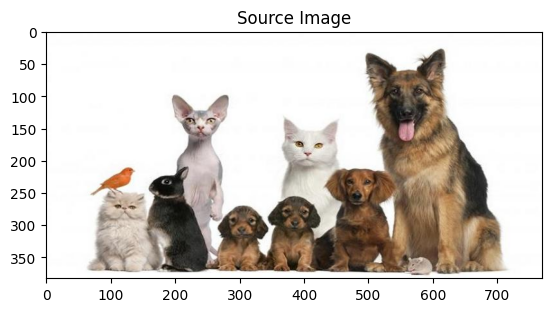

In [11]:
# La posición del path depende del orden de subida de las imagenes a trabajar, si deseas cambiar la imagen,
# modifica el índice de la lista al path de la imagen a usar, no olvidar que los índices empiezan hasta 0
# y van hasta n-1 donde n es el número de imágenes

image_path = image_paths[0]
src_image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Source Image')
plt.show() #Visualización de la imagen seleccionada

### **Creación de máscaras y visualización de Segmentación Panóptica**

In [15]:
# Crear las máscaras usando SAM a partir de la imagen RGB

mask_generator = SamAutomaticMaskGenerator(sam)
src_image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)

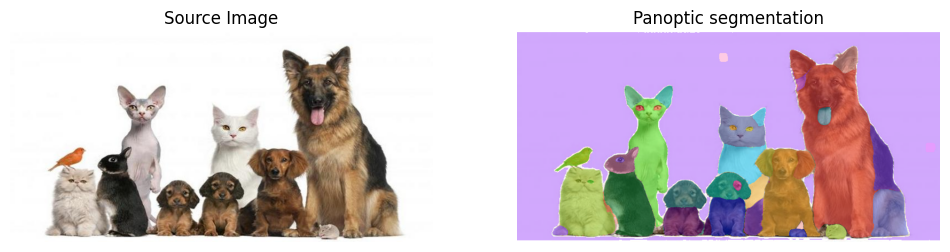

In [16]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=src_image.copy(), detections=detections)

#Visualización de las imágenes
sv.plot_images_grid(
    images=[src_image, annotated_image],
    grid_size=(1, 2),
    titles=['Source Image', 'Panoptic segmentation']
)

### **Visualización de máscaras de segmentación generadas por SAM**

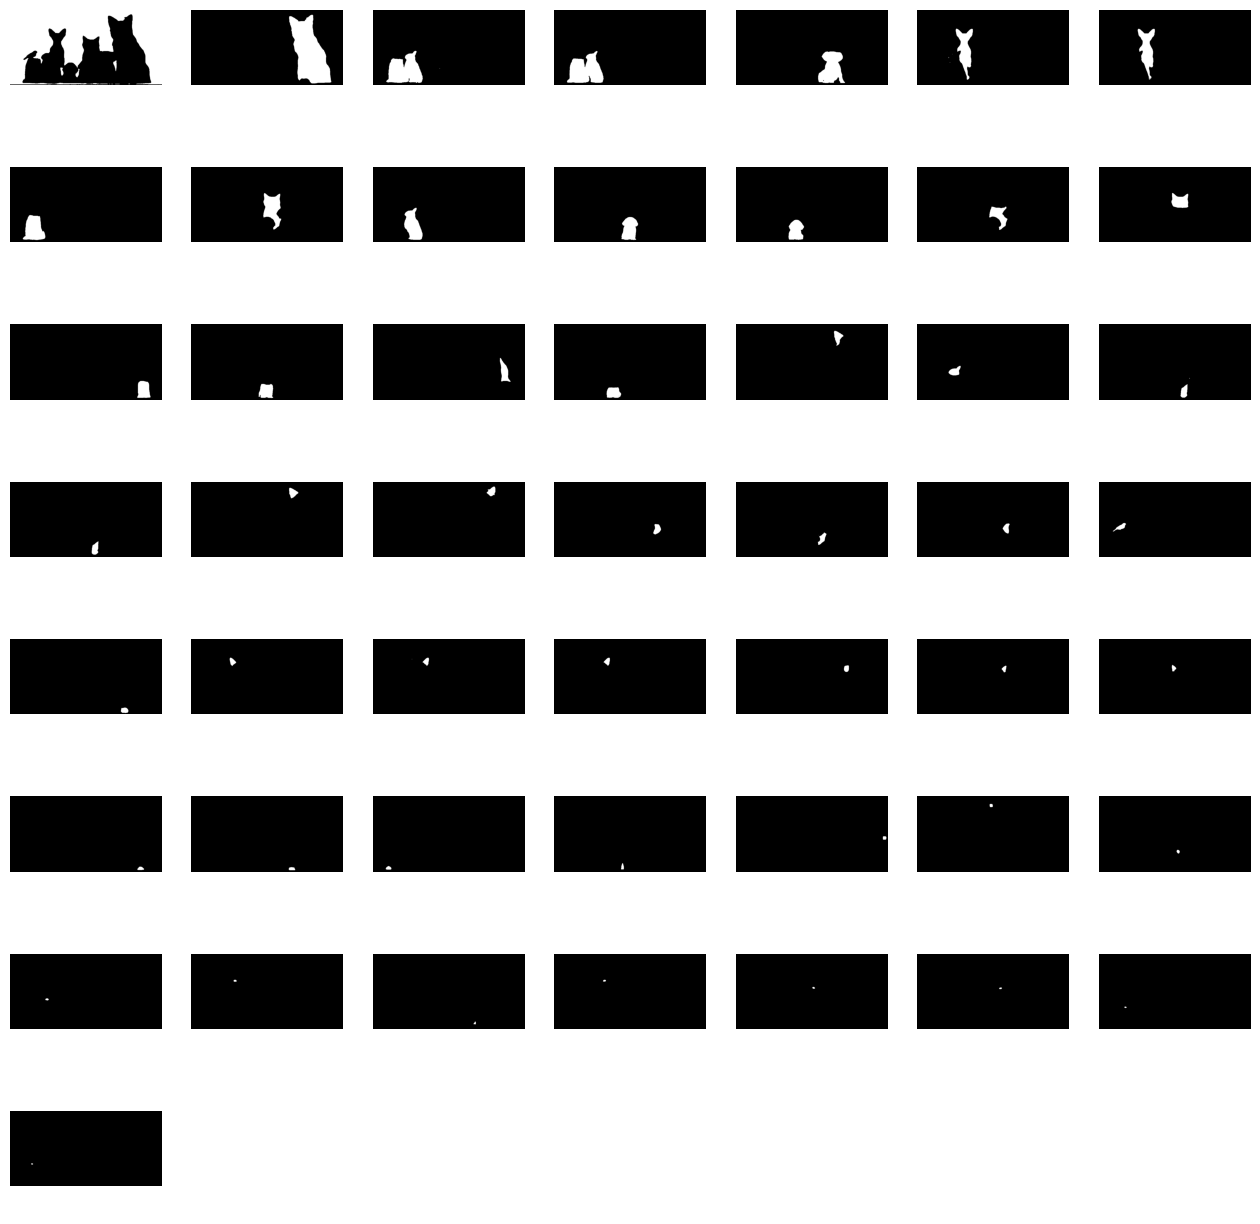

In [17]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

num_rows = (len(masks) + 7) // 8

sv.plot_images_grid(
    images=masks,
    grid_size=(8, num_rows),
    size=(16, 16)
)

## <font color='#00FFFF'> **2. Segmentación semántica** </font>

### **Descargamos Mask2Former desde HuggingFace**

In [18]:
#No modifiques esta sección

In [19]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

In [20]:
#Algunos labels del pre-entreno para buscar imágenes relacionadas a estos

config = model.config
id2label = config.id2label

for id, label in list(id2label.items())[:10]:
  print(f"ID: {id}, Label: {label}")

ID: 0, Label: person
ID: 1, Label: bicycle
ID: 2, Label: car
ID: 3, Label: motorcycle
ID: 4, Label: airplane
ID: 5, Label: bus
ID: 6, Label: train
ID: 7, Label: truck
ID: 8, Label: boat
ID: 9, Label: traffic light


### **Sube cualquier imagen o imágenes aquí para trabajar**

In [21]:
uploaded = files.upload()
image_paths = []

for fn in uploaded.keys():
  if not os.path.exists('uploaded_images'):
    os.makedirs('uploaded_images')

  path = os.path.join('uploaded_images', fn)
  image_paths.append(path)

  with open(path, 'wb') as f:
    f.write(uploaded[fn])

  print('User uploaded file "{name}" with length {length} bytes and saved to {path}'.format(
      name=fn, length=len(uploaded[fn]), path=path))

# Guardamos los paths de cada image en image_path, descomenta la línea de abajo para verlos
#print("Saved image paths:", image_paths)

Saving perros_y_gatos_de_diferentes_razas.jpg to perros_y_gatos_de_diferentes_razas (1).jpg
User uploaded file "perros_y_gatos_de_diferentes_razas (1).jpg" with length 31335 bytes and saved to uploaded_images/perros_y_gatos_de_diferentes_razas (1).jpg


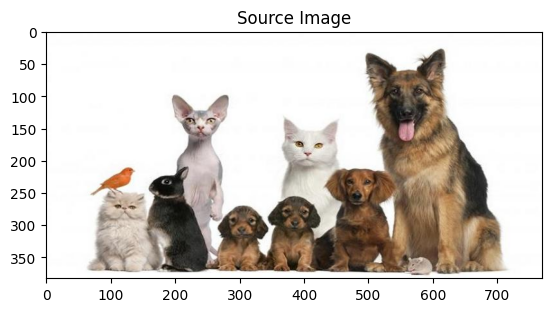

In [22]:
# La posición del path depende del orden de subida de las imagenes a trabajar, si deseas cambiar la imagen,
# modifica el índice de la lista al path de la imagen a usar, no olvidar que los índices empiezan hasta 0
# y van hasta n-1 donde n es el número de imágenes

image = image_paths[0]
src_image = Image.open(image)
plt.imshow(src_image)
plt.title('Source Image')
plt.show() #Visualización de la imagen seleccionada

### **Obtenemos las máscaras de segmentación de Mask2Former**

In [24]:
inputs = processor(images=src_image, return_tensors="pt")

In [25]:
with torch.no_grad():
  outputs = model(**inputs)

In [26]:
predicted_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[src_image.size[::-1]])[0]
print(predicted_map.shape)

torch.Size([383, 770])


In [27]:
color_palette = [list(np.random.choice(range(256), size=3)) for _ in range(len(model.config.id2label))]
print(color_palette)

[[np.int64(226), np.int64(56), np.int64(178)], [np.int64(19), np.int64(234), np.int64(10)], [np.int64(171), np.int64(76), np.int64(102)], [np.int64(160), np.int64(194), np.int64(184)], [np.int64(89), np.int64(234), np.int64(172)], [np.int64(117), np.int64(80), np.int64(99)], [np.int64(120), np.int64(253), np.int64(225)], [np.int64(47), np.int64(127), np.int64(173)], [np.int64(24), np.int64(7), np.int64(86)], [np.int64(105), np.int64(250), np.int64(208)], [np.int64(202), np.int64(164), np.int64(32)], [np.int64(125), np.int64(18), np.int64(218)], [np.int64(231), np.int64(8), np.int64(24)], [np.int64(19), np.int64(202), np.int64(44)], [np.int64(253), np.int64(42), np.int64(210)], [np.int64(178), np.int64(51), np.int64(171)], [np.int64(123), np.int64(44), np.int64(111)], [np.int64(75), np.int64(213), np.int64(181)], [np.int64(204), np.int64(212), np.int64(194)], [np.int64(25), np.int64(105), np.int64(60)], [np.int64(102), np.int64(119), np.int64(192)], [np.int64(195), np.int64(183), np.int

### **Visualización de Segmentación Semántica**

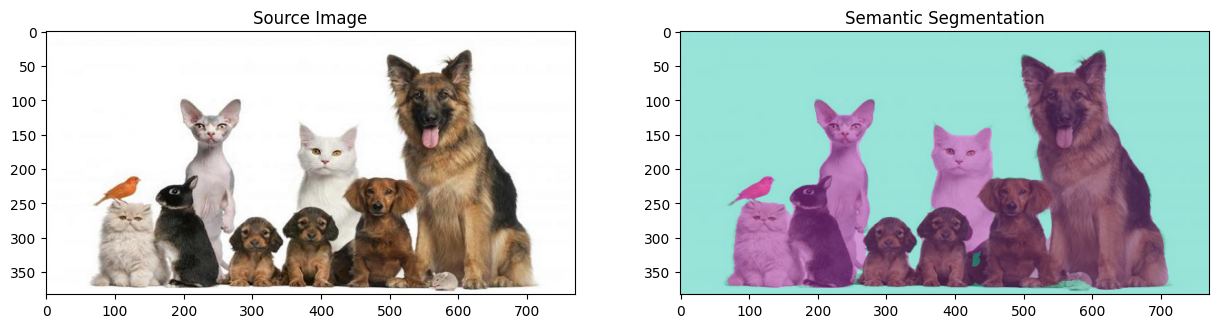

In [28]:
seg = predicted_map # Cambio de nombre de una variable anterior
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
palette = np.array(color_palette)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

img = np.array(src_image)
color_seg_resized = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Imagen y máscara (NO modificar 🙏🏼)
img = img * 0.5 + color_seg_resized * 0.5
img = img.astype(np.uint8)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

#Visualización de las imágenes
axes[0].imshow(src_image)
axes[0].set_title('Source Image')
axes[1].imshow(img)
axes[1].set_title('Semantic Segmentation')

plt.show()

## <font color='#00FFFF'> **3. Segmentación de instancias** </font>

### **Sube cualquier imagen o imágenes aquí para trabajar**

In [29]:
uploaded = files.upload()
image_paths = []

for fn in uploaded.keys():
  if not os.path.exists('uploaded_images'):
    os.makedirs('uploaded_images')

  path = os.path.join('uploaded_images', fn)
  image_paths.append(path)

  with open(path, 'wb') as f:
    f.write(uploaded[fn])

  print('User uploaded file "{name}" with length {length} bytes and saved to {path}'.format(
      name=fn, length=len(uploaded[fn]), path=path))

# Guardamos los paths de cada image en image_path, descomenta la línea de abajo para verlos
#print("Saved image paths:", image_paths)

Saving images.jpg to images.jpg
User uploaded file "images.jpg" with length 22121 bytes and saved to uploaded_images/images.jpg


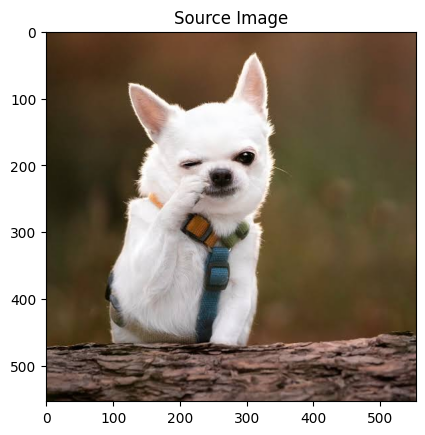

In [30]:
# La posición del path depende del orden de subida de las imagenes a trabajar, si deseas cambiar la imagen,
# modifica el índice de la lista al path de la imagen a usar, no olvidar que los índices empiezan hasta 0
# y van hasta n-1 donde n es el número de imágenes

image = image_paths[0]
src_image = Image.open(image)
plt.imshow(src_image)
plt.title('Source Image')
plt.show() #Visualización de la imagen seleccionada

### **Obtenemos las máscaras de segmentación de Mask2Former**

In [31]:
inputs = processor(images=src_image, return_tensors="pt")

In [32]:
with torch.no_grad():
  outputs = model(**inputs)

In [33]:
results = processor.post_process_instance_segmentation(outputs, target_sizes=[src_image.size[::-1]], threshold=0.9)[0]
print(results.keys())

dict_keys(['segmentation', 'segments_info'])


In [34]:
#Obtención de los IDs de las máscaras para revisarlas de forma individual

segment_to_label = {segment['id']: segment['label_id'] for segment in results["segments_info"]}

def get_available_segment_ids(results):

    segmentation = results['segmentation'].numpy()
    unique_ids = np.unique(segmentation)

    available_ids = [id for id in unique_ids]

    return available_ids

available_ids = get_available_segment_ids(results)
print("Available segment IDs:", [id.item() for id in available_ids])

Available segment IDs: [-1.0, 0.0, 1.0]


Visualizing mask for: dog


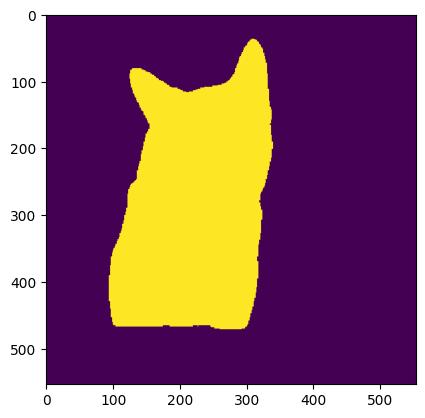

In [35]:
# Visualización individual de máscaras
def get_mask(segment_id):
  if segment_id in segment_to_label:
    print("Visualizing mask for:", model.config.id2label[segment_to_label[segment_id]])

    mask = (results['segmentation'].numpy() == segment_id)
    visual_mask = (mask * 255).astype(np.uint8)
    visual_mask = Image.fromarray(visual_mask)

    plt.imshow(visual_mask)
    plt.show()
  else:
    print(f"Segment ID {segment_id} not found in segment_to_label. Skipping visualization.")
    return None

get_mask(segment_id=0)

### **Visualización Segmentación de Instancias**

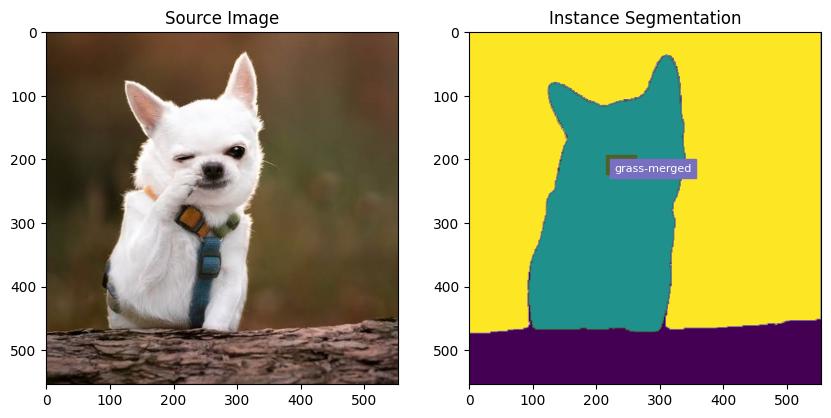

In [37]:
def draw_instance_segmentation(segmentation, segments_info):

    fig, axes_arr = plt.subplots(1, 2, figsize=(10, 8)) # Create 2 subplots
    axes_img, axes_seg = axes_arr

    axes_img.imshow(src_image)
    axes_img.set_title('Source Image')
    axes_seg.imshow(segmentation)
    axes_seg.set_title('Instance Segmentation')

    instance_colors = {}
    for segment in segments_info:
        segment_id = segment['id']
        if segment_id not in instance_colors:
            instance_colors[segment_id] = [random.randint(0, 255) for _ in range(3)]

    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]

        mask = (segmentation.numpy() == segment_id)

        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            axes_seg.plot(contour[:, 0, 0], contour[:, 0, 1], color=np.array(instance_colors[segment_id]) / 255, linewidth=0.5)

        x, y = np.mean(contour, axis=0)[0]
        axes_seg.text(x, y, segment_label, color='white', backgroundcolor=np.array(instance_colors[segment_id]) / 255, fontsize=8)

    plt.show()
#Visualización de las imágenes
draw_instance_segmentation(**results)

## <font color='#00FFFF'> **Bibliografía** </font>

Piotr Skalski. (Jan 22, 2024). How to Use the Segment Anything Model (SAM). Roboflow Blog: https://blog.roboflow.com/how-to-use-segment-anything-model-sam/

Jacob Solawetz. (Apr 7, 2023). What is Segment Anything Model (SAM)? A Breakdown.. Roboflow Blog: https://blog.roboflow.com/segment-anything-breakdown/

Rogge, N. (2025). Tutorials. Github Repository: https://github.com/NielsRogge/Transformers-Tutorials

Cheng, B., Misra, I., Schwing, A. G., Kirillov, A., & Girdhar, R. (2022). Masked-attention Mask Transformer for Universal Image Segmentation. arXiv. https://arxiv.org/abs/2112.01527

Kirillov, A., Mintun, E., Ravi, N., Mao, H., Rolland, C., Gustafson, L., Xiao, T., Whitehead, S., Berg, A. C., Lo, W.-Y., Dollár, P., & Girshick, R. (2023). Segment Anything. arXiv. https://arxiv.org/abs/2304.02643